## Exploring the Impact of Convolution Layers Unit Configurations on EEG Classification Performance

### Experiment Summary

In this experiment, we trained and evaluated a total of 25 models for EEG classification using different combinations of convolutional layers units. The configurations define the ranges of units to be explored.

For each model, 5 fold cross-validation is performed, and the model is trained using the Adam optimizer and binary cross-entropy loss. The best model based on validation accuracy is saved using the `ModelCheckpoint` callback. Total 125 model was trained.

Training progress, including loss and accuracy, is logged for each model, and evaluation metrics are recorded. Accuracy plots are generated for each model configuration.

The average accuracy across all folds is calculated for each model configuration, providing insights into the performance of different combinations of convolutional units.

**The purpose of the code is to exhaustively search for the best model architecture for EEG classification based on the provided convolutional unit configurations. By training and evaluating multiple models, the code aims to identify the optimal architecture that yields the highest accuracy.**

In summary, we performed an extensive search over different combinations of convolutional units, trains and evaluates multiple models using cross-validation, and logs the training progress and accuracy metrics for each model configuration.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%mkdir /content/drive/MyDrive/ED_experiments/ED_CNN_01
%cd /content/drive/MyDrive/ED_experiments/ED_CNN_01
%ls

/content/drive/MyDrive/ED_experiments/ED_CNN_01


## Import libraries

In [ ]:
import sys
import os
import logging


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input, LSTM
from keras.layers import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


In [ ]:
## seed
np.random.seed(2023)

## Reading CSV data

In [ ]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/mamuncseru/analysis_on_epileptic_seizure_bonn_dataset/main/Epileptic%20Seizure%20Recognition.csv')
raw_data.shape

(11500, 180)

In [ ]:
raw_data

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,X22.V1.114,-22,-22,-23,-26,-36,-42,-45,-42,-45,...,15,16,12,5,-1,-18,-37,-47,-48,2
11496,X19.V1.354,-47,-11,28,77,141,211,246,240,193,...,-65,-33,-7,14,27,48,77,117,170,1
11497,X8.V1.28,14,6,-13,-16,10,26,27,-9,4,...,-65,-48,-61,-62,-67,-30,-2,-1,-8,5
11498,X10.V1.932,-40,-25,-9,-12,-2,12,7,19,22,...,121,135,148,143,116,86,68,59,55,3


In [ ]:
raw_data.values.shape

(11500, 180)

In [ ]:
data = raw_data.values # converted to an numpy array
data = data[:, 1:] # discarding the Unnamed Column
data.shape

(11500, 179)

In [ ]:
# let's see how it looks like
data

array([[135, 190, 229, ..., -83, -51, 4],
       [386, 382, 356, ..., 143, 129, 1],
       [-32, -39, -47, ..., -35, -36, 5],
       ...,
       [14, 6, -13, ..., -1, -8, 5],
       [-40, -25, -9, ..., 59, 55, 3],
       [29, 41, 57, ..., 2, 20, 4]], dtype=object)

In [ ]:
# let's see the type
type(data)

numpy.ndarray

## Classifying data categories as it mentioned in the paper

In [ ]:
df_1 = data[data[:, -1] == 1].astype(int) # seizure
df_2 = data[data[:, -1] == 2].astype(int)
df_3 = data[data[:, -1] == 3].astype(int)
df_4 = data[data[:, -1] == 4].astype(int)
df_5 = data[data[:, -1] == 5].astype(int)

# let's print the shape of each category
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)
print(df_4.shape)
print(df_5.shape)

(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)
(2300, 179)


## Let's plot some random data points from every category

In [ ]:
def visualize_eeg(number_of_datapoints):
    for i in (np.random.randint(0, 2300, number_of_datapoints)):
        plt.plot(df_1[i, :], 'r-', label='df_1')
        plt.plot(df_2[i, :], 'g-', label='df_2')
        plt.plot(df_3[i, :], 'k-', label='df_3')
        plt.plot(df_4[i, :], 'b-', label='df_4')
        plt.plot(df_5[i, :], 'm-', label='df_5')
        plt.legend()
        plt.title(f'visualizing {i} th data point')
        plt.xlabel('time')
        plt.ylabel('aplitude(uV)')
        plt.show()

### Visualizing all categories in single figure

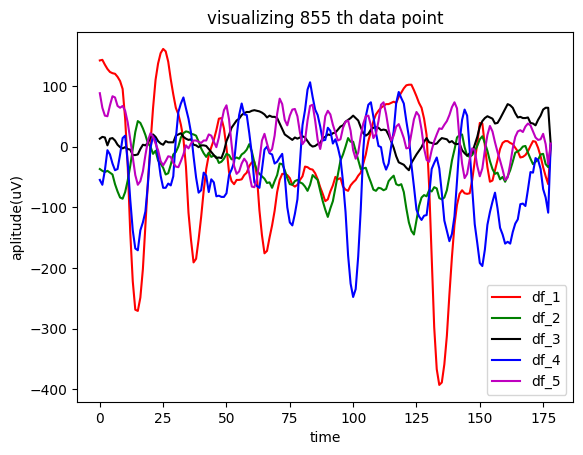

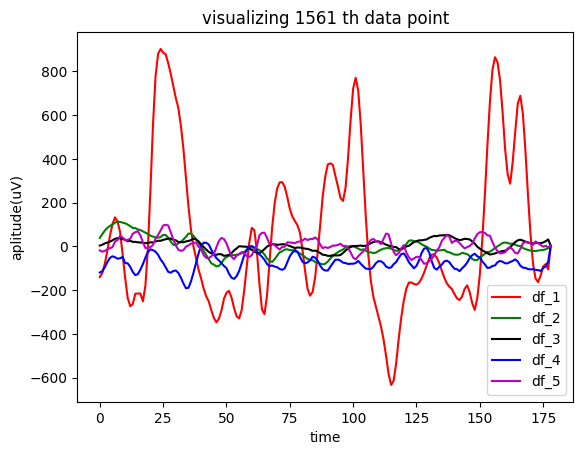

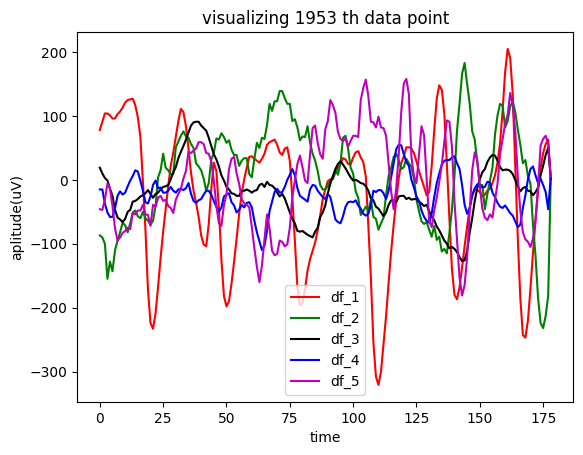

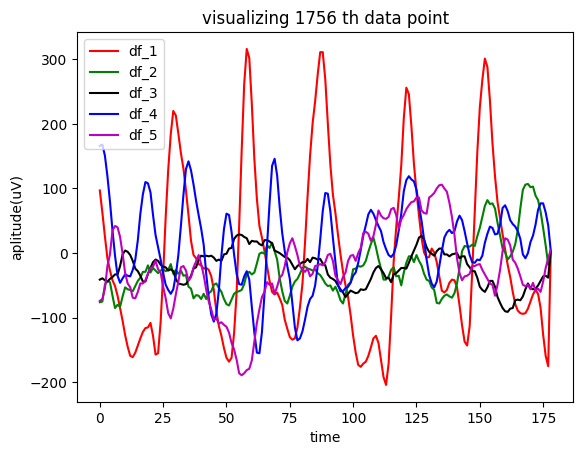

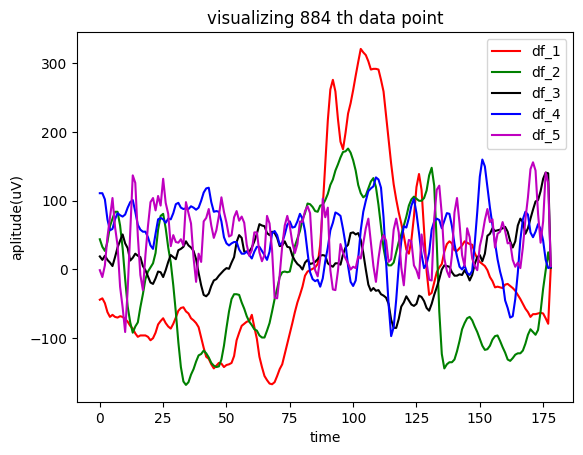

In [ ]:
### all categories
visualize_eeg(5)

## Converting data into integer and making the data into seizure and non-seizure cateogry

In [ ]:
all_data = data.copy().astype('int')

In [ ]:
all_data

array([[135, 190, 229, ..., -83, -51,   4],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   5],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   5],
       [-40, -25,  -9, ...,  59,  55,   3],
       [ 29,  41,  57, ...,   2,  20,   4]])

In [ ]:
all_data[:, -1] = np.where(all_data[:, -1] != 1, 0, all_data[:, -1])
all_data

array([[135, 190, 229, ..., -83, -51,   0],
       [386, 382, 356, ..., 143, 129,   1],
       [-32, -39, -47, ..., -35, -36,   0],
       ...,
       [ 14,   6, -13, ...,  -1,  -8,   0],
       [-40, -25,  -9, ...,  59,  55,   0],
       [ 29,  41,  57, ...,   2,  20,   0]])

In [ ]:
print(len(all_data[all_data[:, -1] == 1]))
print(len(all_data[all_data[:, -1] == 0]))

2300
9200


## Plot functions

### function to plot loss curve of the
- (training and validation loss) and
- (training and validation accuracy)


In [ ]:
def plot_loss_accuracy(history, title):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(history.history['loss'], 'b-')
    ax[0].plot(history.history['val_loss'], 'r-')
    ax[0].legend(['train_loss', 'val_loss'])
    ax[0].set_title('Loss curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss %')

    ax[1].plot(history.history['accuracy'], 'b-')
    ax[1].plot(history.history['val_accuracy'], 'r-')
    ax[1].legend(['train_accuracy', 'val_accuracy'])
    ax[1].set_title('Accuracy curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('accuracy %')

    plt.suptitle(title)
    plt.savefig(title + '.png')

    plt.show()

In [ ]:
# Initialize StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

In [ ]:
def input_output_data(data, random_state=2023):

    X = all_data[:, :-1]
    y = all_data[:, -1]

    return X, y

X, y = input_output_data(data)

In [ ]:
def process_input(X, y, train_index, val_index):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = np.expand_dims(X_train, axis=2)
    X_val = np.expand_dims(X_val, axis=2)

    input_shape = (X_train.shape[1], 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')

    return X_train, X_val, y_train, y_val, input_shape

## Logger Setup

In [ ]:
import absl.logging
import sys
import logging
absl.logging.set_verbosity(absl.logging.ERROR)
absl.logging.set_verbosity(absl.logging.INFO)

In [ ]:
def init_logger(log_file, log_level=logging.INFO, stdout=True):
    logger = logging.getLogger()
    logger.setLevel(log_level)

    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    file_handler = logging.FileHandler(log_file, mode='w')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    if stdout:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(formatter)
        logger.addHandler(console_handler)

    return logger


## Let's experiment with the number of units in conv1, conv2 layers

```
conv1 = [32, 64, 128, 256, 512]

conv2 = [64, 128, 256, 512, 1024]
```


### Experimental Model

In [ ]:
# class eegClassifier(keras.Model):
#     def __init__(self, input_shape, c1_units, c2_units):
#         super(eegClassifier, self).__init__()

#         self.conv1 = layers.Conv1D(filters=c1_units, kernel_size=5, input_shape=input_shape)
#         self.bn_1 = BatchNormalization()
#         self.max_pool_1 = layers.MaxPooling1D(2, padding='same')

#         self.conv2 = layers.Conv1D(filters=c2_units, kernel_size=3)
#         self.bn_2 = BatchNormalization()
#         self.max_pool_2 = layers.MaxPooling1D(2, padding='same')

#         self.flatten = Flatten()

#         self.dense_1 = Dense(32)
#         self.dense_2 = Dense(16)

#         self.output_dense = Dense(1, activation='sigmoid')

#     def call(self, inputs):
#         x = self.conv1(inputs)
#         x = tf.nn.relu(self.bn_1(x))
#         x = self.max_pool_1(x)

#         x = self.conv2(x)
#         x = tf.nn.relu(self.bn_2(x))
#         x = self.max_pool_2(x)

#         x = self.flatten(x)
#         x = self.dense_1(x)
#         x = tf.nn.relu(x)
#         x = self.dense_2(x)
#         x = tf.nn.relu(x)
#         return self.output_dense(x)



In [ ]:
def create_sequential_eeg_model(input_shape, c1_units, c2_units):
    model = keras.Sequential()

    model.add(layers.Conv1D(filters=c1_units, kernel_size=5, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))

    model.add(layers.Conv1D(filters=c2_units, kernel_size=3))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2, padding='same'))

    model.add(layers.Flatten())

    model.add(layers.Dense(32))
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(16))
    model.add(layers.Activation('relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    return model



---- fold = 1 --- conv1 unit = 32 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1774 - accuracy: 0.9752
c1=32,c2=64 Fold = 1 accuracy: 0.9752174019813538


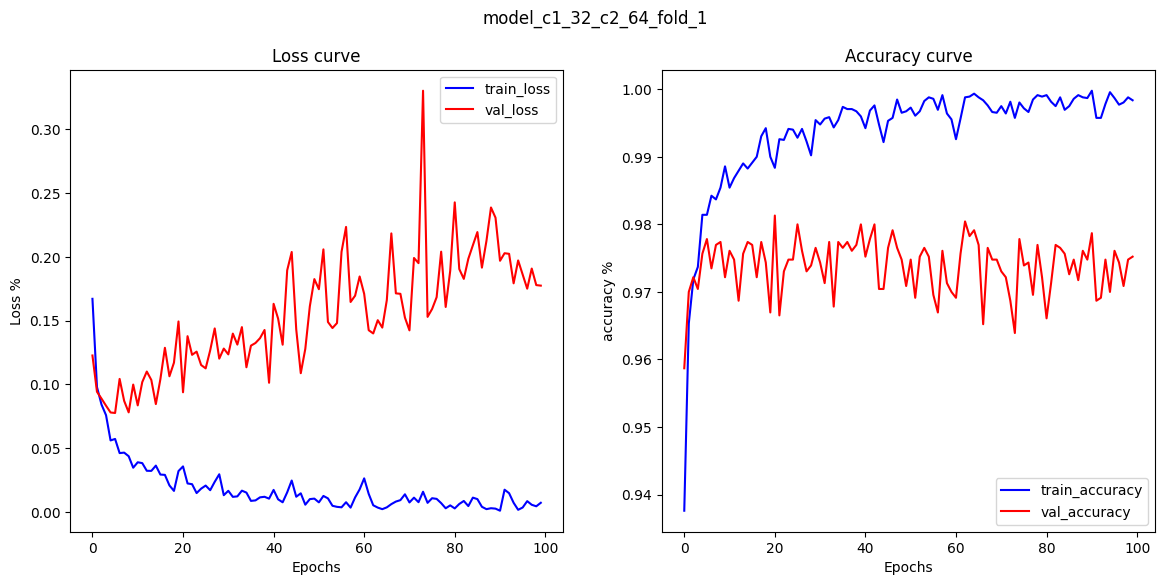



---- fold = 2 --- conv1 unit = 32 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1225 - accuracy: 0.9778
c1=32,c2=64 Fold = 2 accuracy: 0.9778260588645935


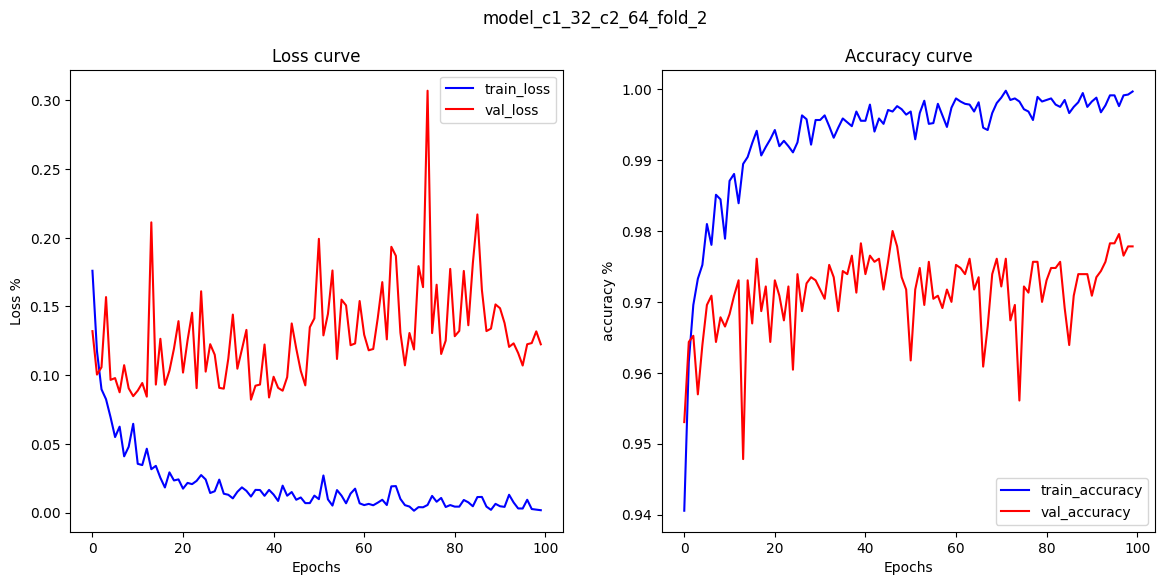



---- fold = 3 --- conv1 unit = 32 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1185 - accuracy: 0.9804
c1=32,c2=64 Fold = 3 accuracy: 0.980434775352478


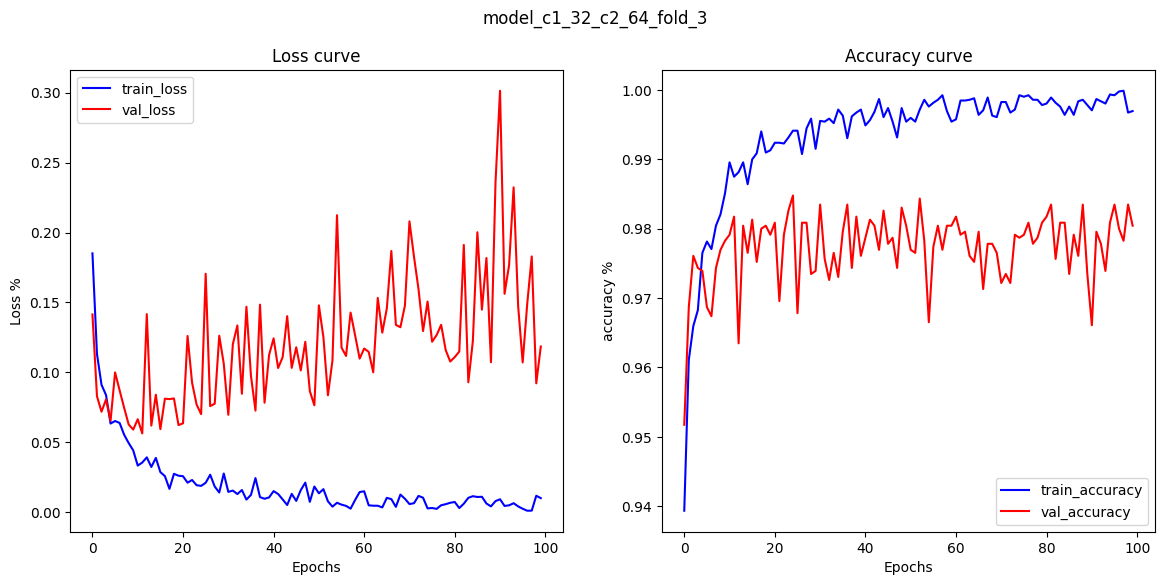



---- fold = 4 --- conv1 unit = 32 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1618 - accuracy: 0.9713
c1=32,c2=64 Fold = 4 accuracy: 0.9713043570518494


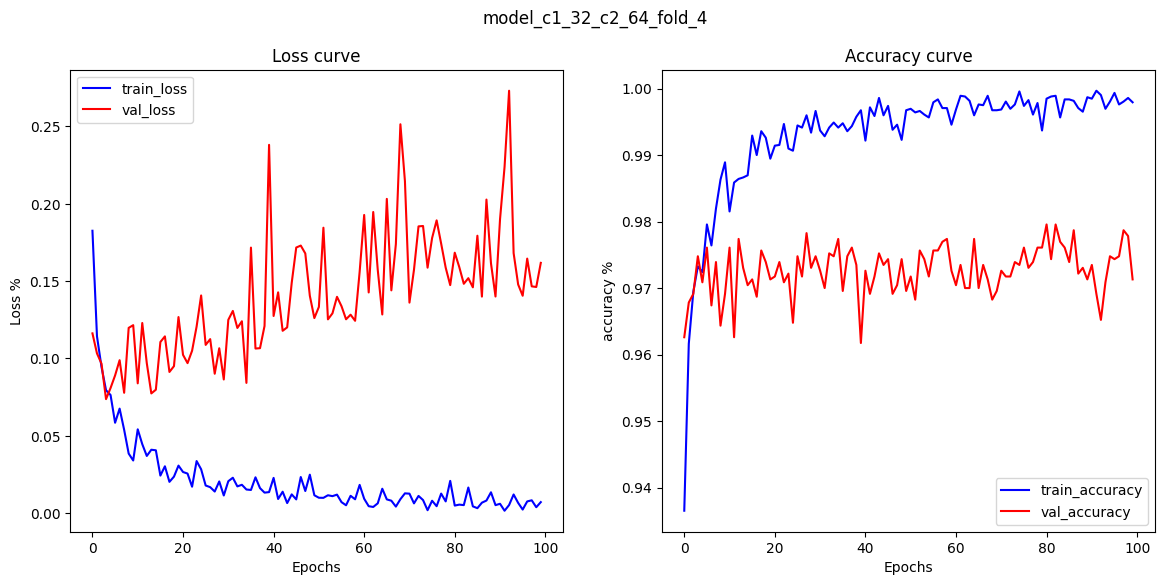



---- fold = 5 --- conv1 unit = 32 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.0965 - accuracy: 0.9783
c1=32,c2=64 Fold = 5 accuracy: 0.97826087474823


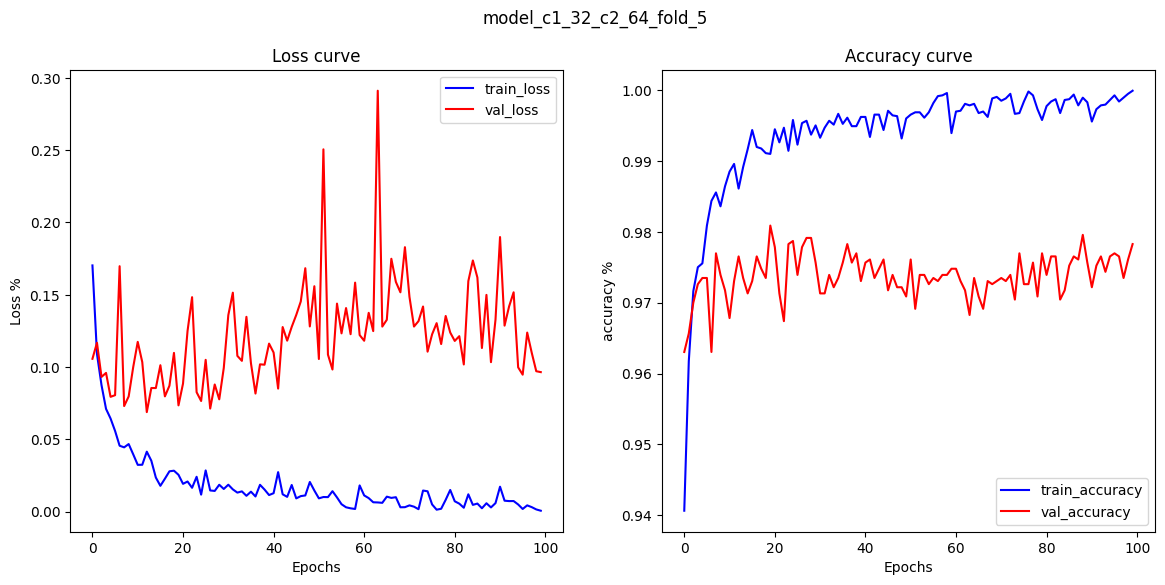

Mean Accuracy: 0.9766086935997009


---- fold = 1 --- conv1 unit = 32 ---- conv2 unit = 128 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9800
c1=32,c2=128 Fold = 1 accuracy: 0.9800000190734863


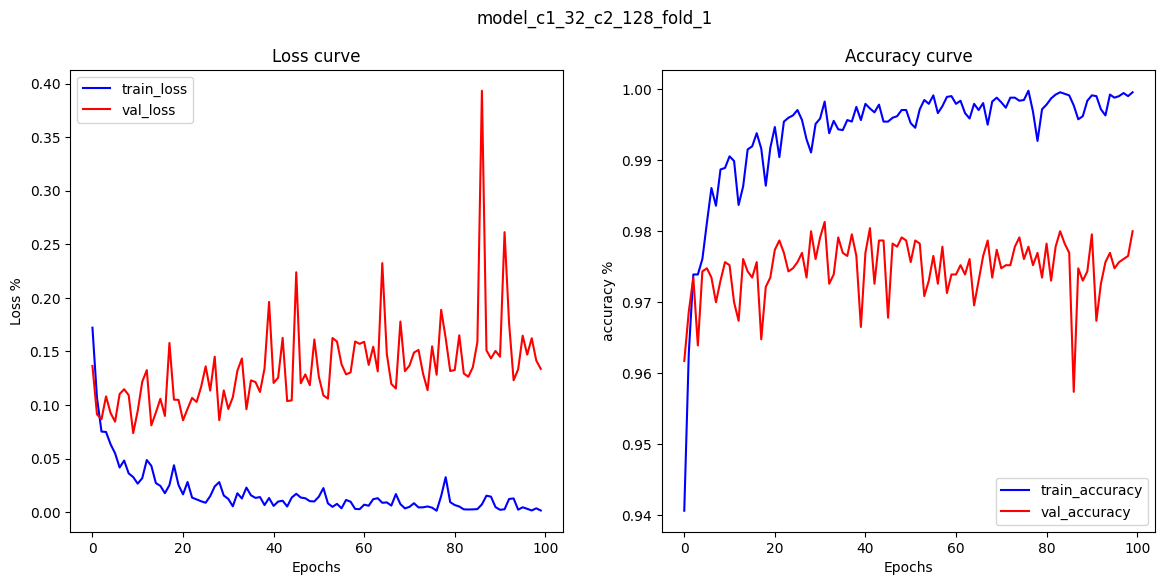



---- fold = 2 --- conv1 unit = 32 ---- conv2 unit = 128 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1894 - accuracy: 0.9704
c1=32,c2=128 Fold = 2 accuracy: 0.9704347848892212


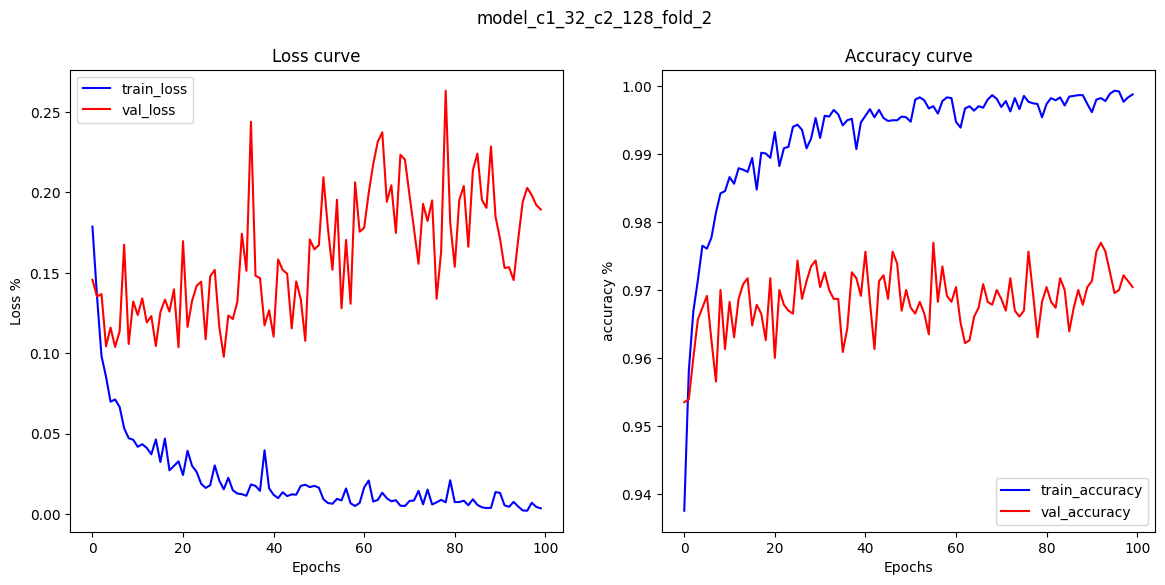



---- fold = 3 --- conv1 unit = 32 ---- conv2 unit = 128 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1685 - accuracy: 0.9752
c1=32,c2=128 Fold = 3 accuracy: 0.9752174019813538


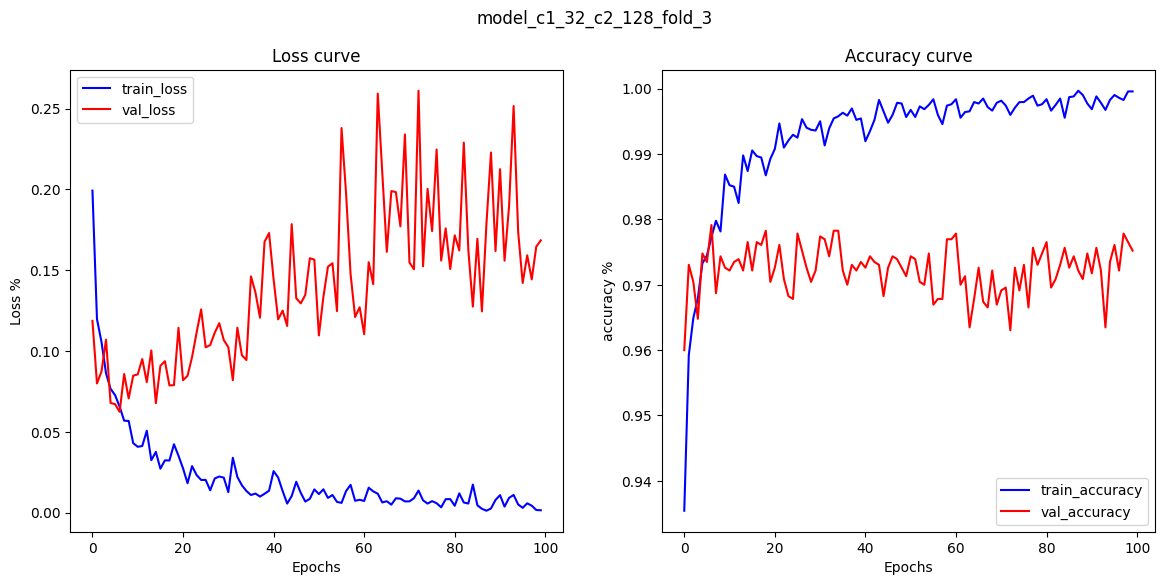



---- fold = 4 --- conv1 unit = 32 ---- conv2 unit = 128 -------

72/72 [==============================] - 0s 5ms/step - loss: 0.1118 - accuracy: 0.9791
c1=32,c2=128 Fold = 4 accuracy: 0.9791304469108582


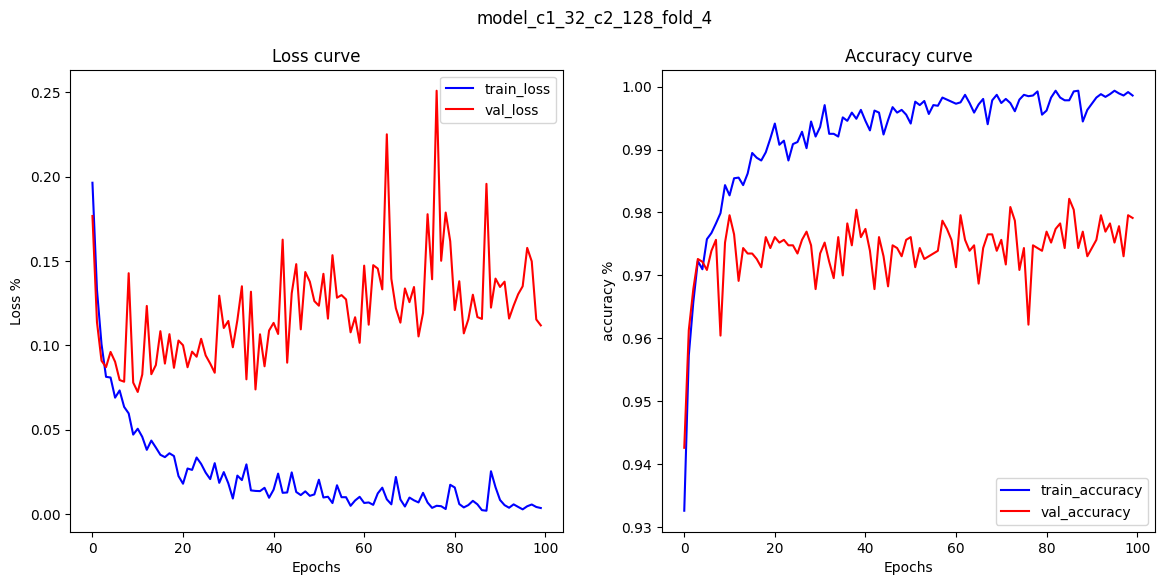



---- fold = 5 --- conv1 unit = 32 ---- conv2 unit = 128 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1801 - accuracy: 0.9735
c1=32,c2=128 Fold = 5 accuracy: 0.9734782576560974


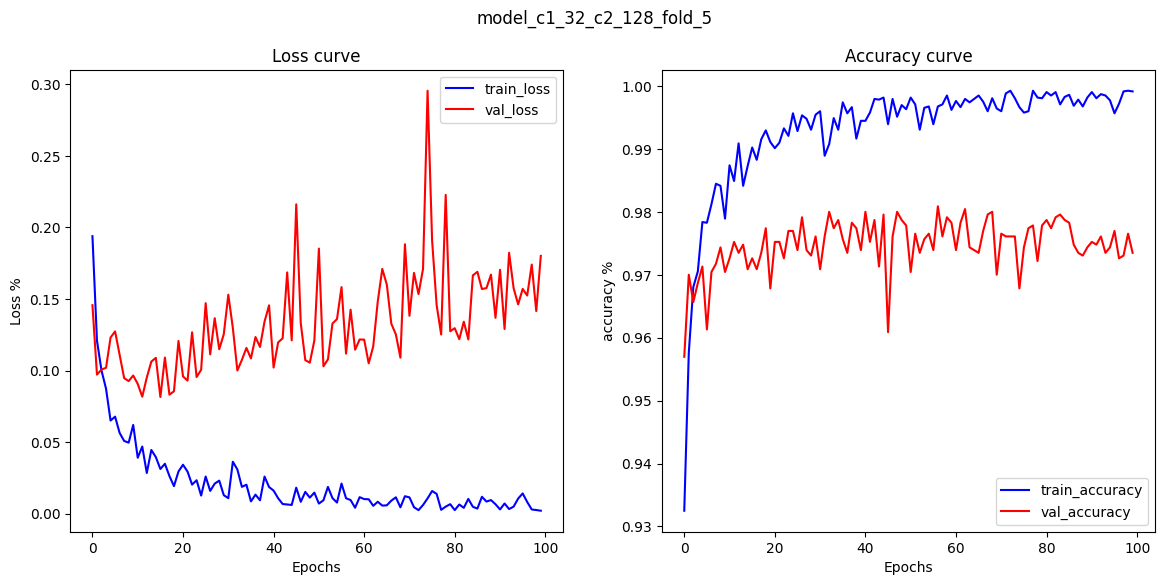

Mean Accuracy: 0.9756521821022034


---- fold = 1 --- conv1 unit = 32 ---- conv2 unit = 256 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1860 - accuracy: 0.9765
c1=32,c2=256 Fold = 1 accuracy: 0.9765217304229736


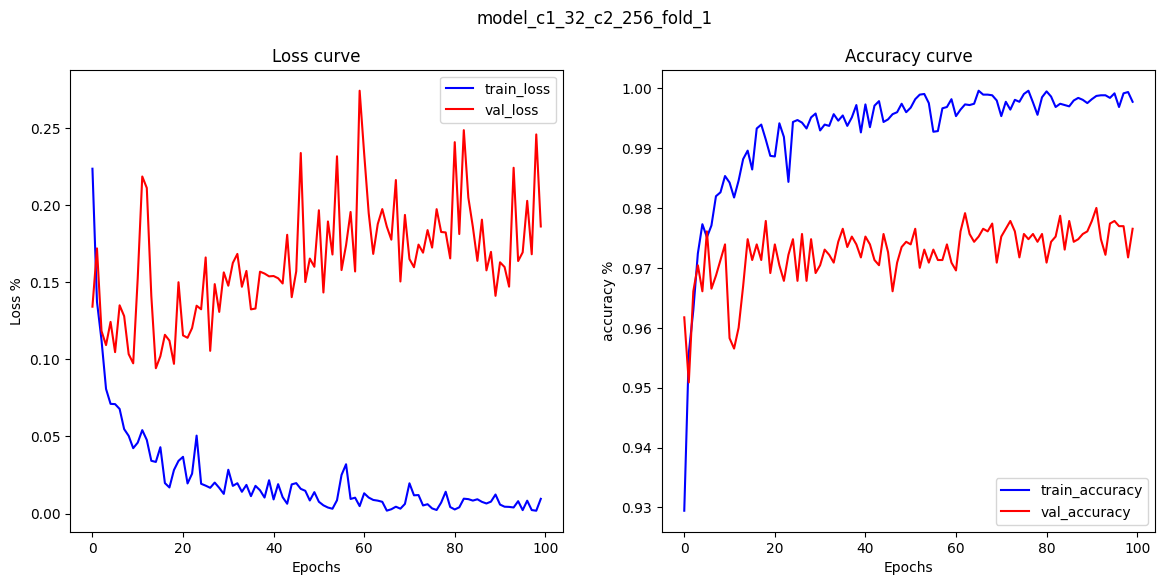



---- fold = 2 --- conv1 unit = 32 ---- conv2 unit = 256 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.2181 - accuracy: 0.9674
c1=32,c2=256 Fold = 2 accuracy: 0.967391312122345


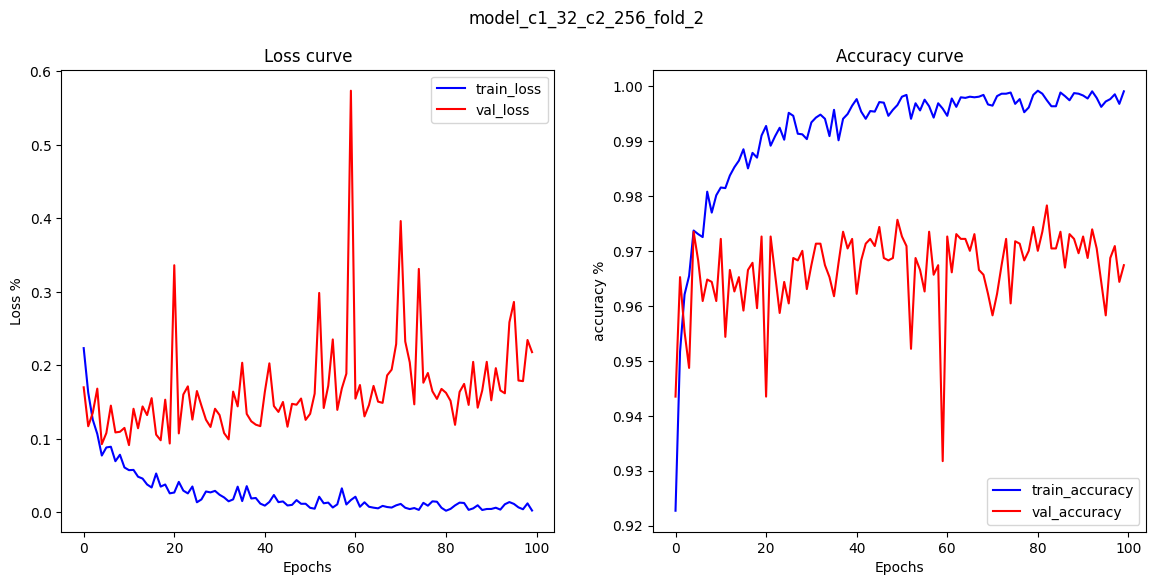



---- fold = 3 --- conv1 unit = 32 ---- conv2 unit = 256 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1222 - accuracy: 0.9770
c1=32,c2=256 Fold = 3 accuracy: 0.9769565463066101


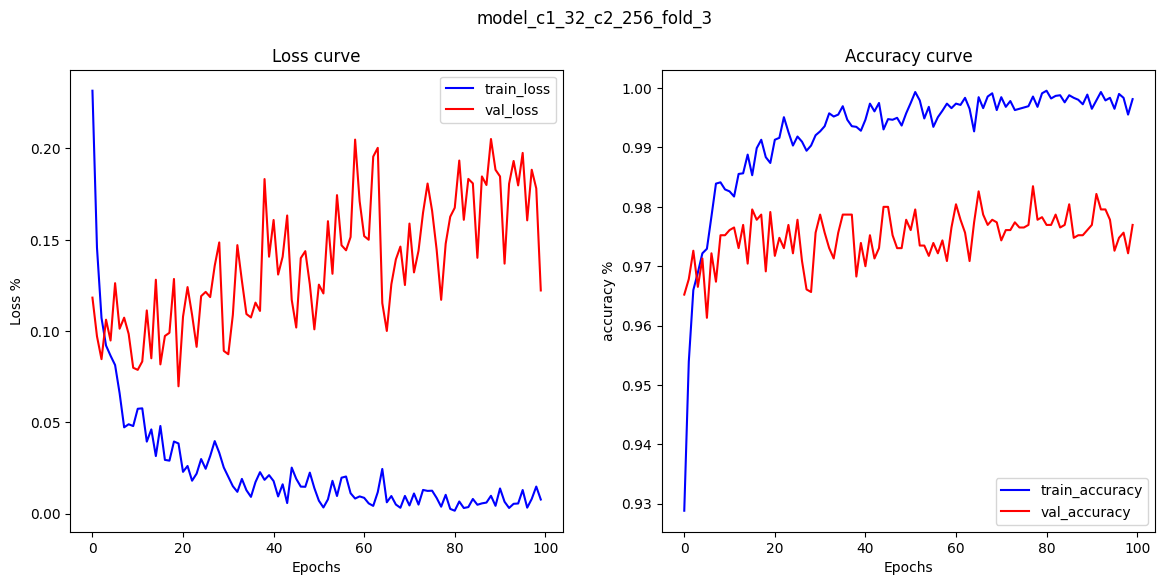



---- fold = 4 --- conv1 unit = 32 ---- conv2 unit = 256 -------

72/72 [==============================] - 0s 3ms/step - loss: 0.1524 - accuracy: 0.9765
c1=32,c2=256 Fold = 4 accuracy: 0.9765217304229736


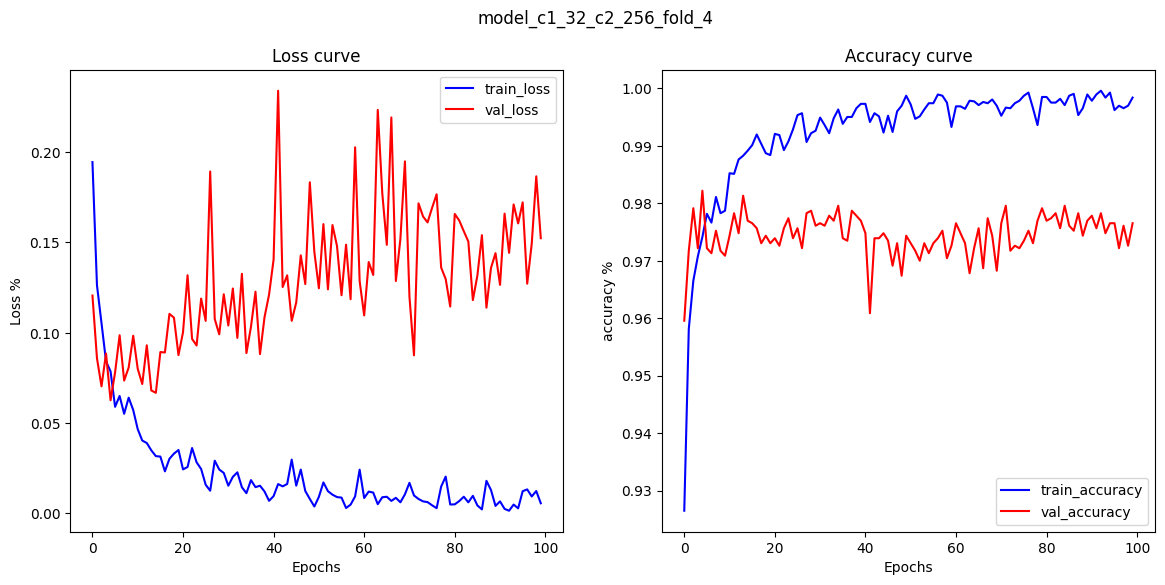



---- fold = 5 --- conv1 unit = 32 ---- conv2 unit = 256 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.2753 - accuracy: 0.9674
c1=32,c2=256 Fold = 5 accuracy: 0.967391312122345


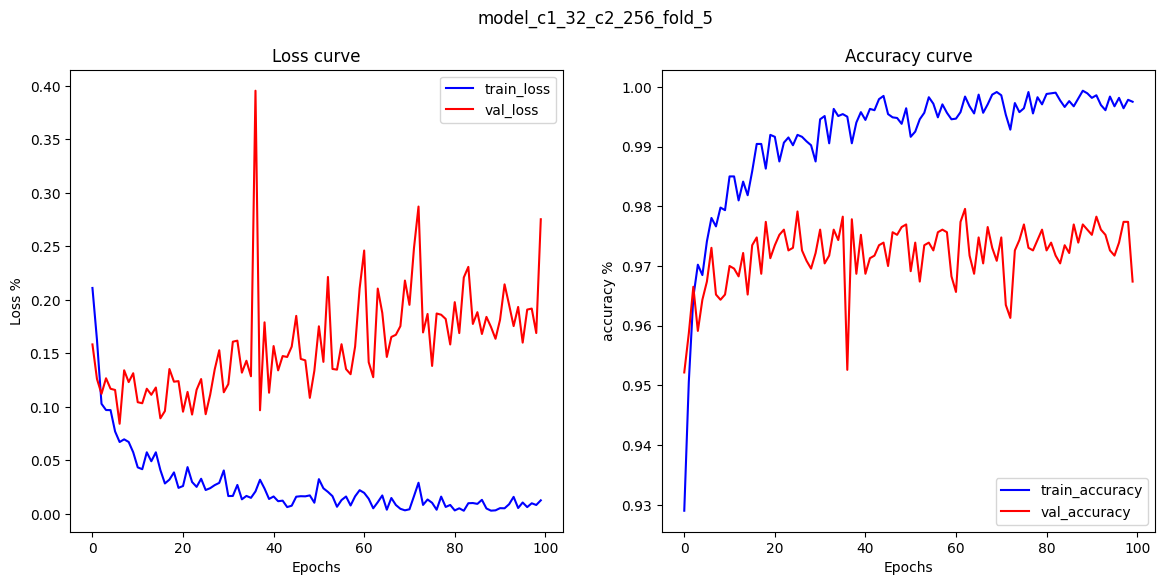

Mean Accuracy: 0.9729565262794495


---- fold = 1 --- conv1 unit = 32 ---- conv2 unit = 512 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9757
c1=32,c2=512 Fold = 1 accuracy: 0.9756521582603455


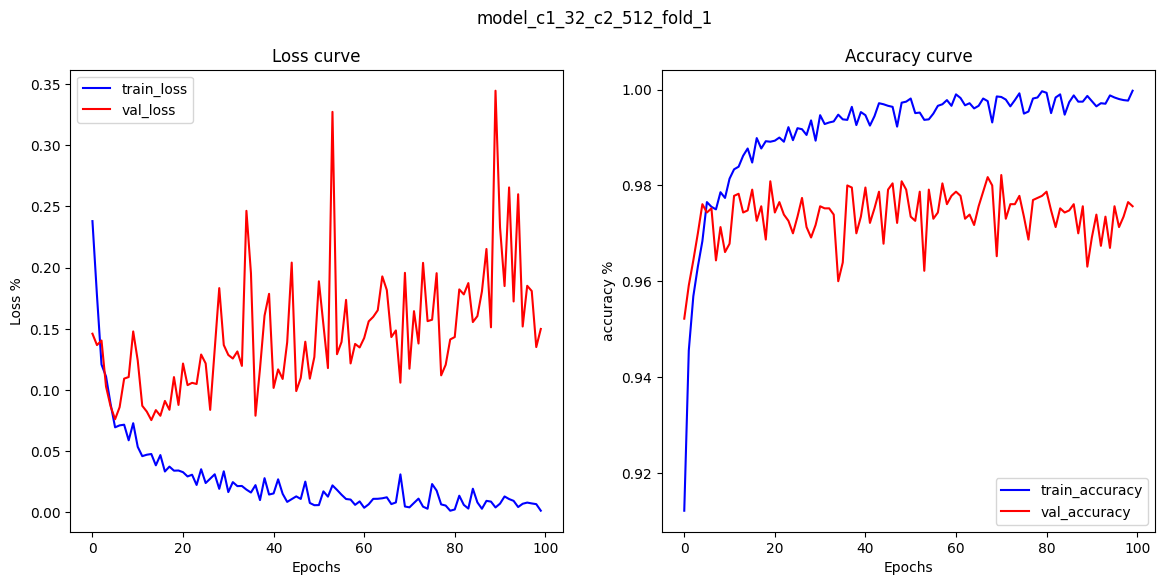



---- fold = 2 --- conv1 unit = 32 ---- conv2 unit = 512 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1432 - accuracy: 0.9709
c1=32,c2=512 Fold = 2 accuracy: 0.9708695411682129


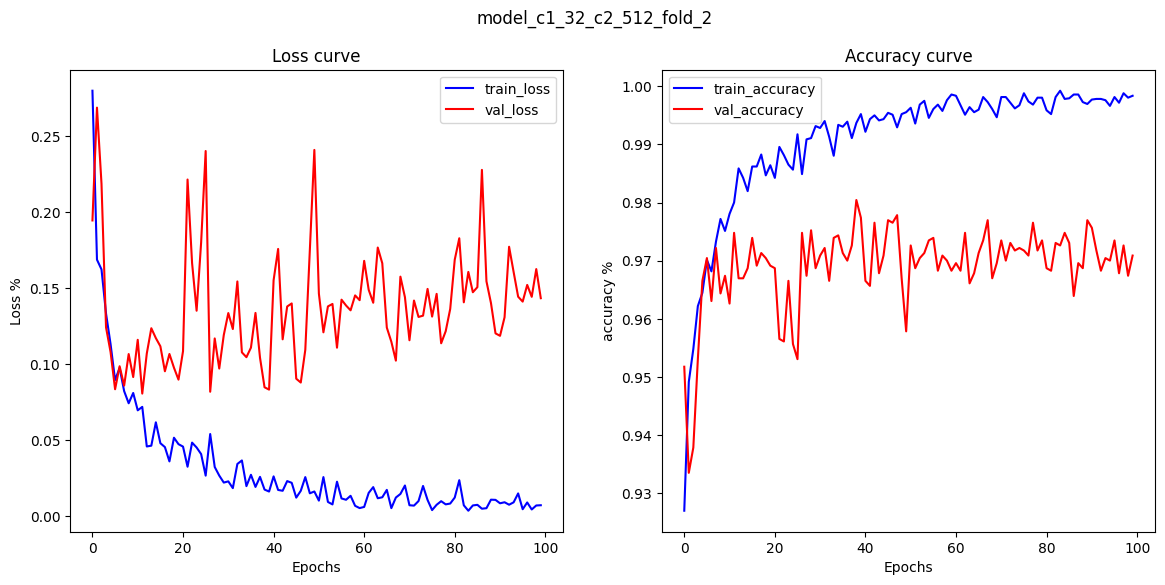



---- fold = 3 --- conv1 unit = 32 ---- conv2 unit = 512 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1535 - accuracy: 0.9748
c1=32,c2=512 Fold = 3 accuracy: 0.9747825860977173


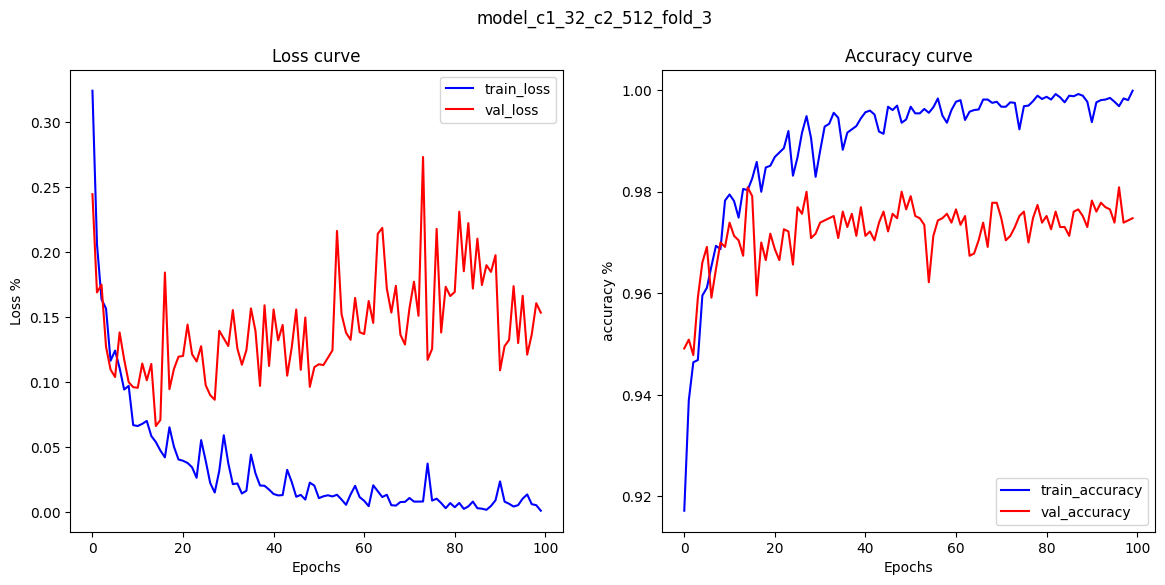



---- fold = 4 --- conv1 unit = 32 ---- conv2 unit = 512 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1827 - accuracy: 0.9770
c1=32,c2=512 Fold = 4 accuracy: 0.9769565463066101


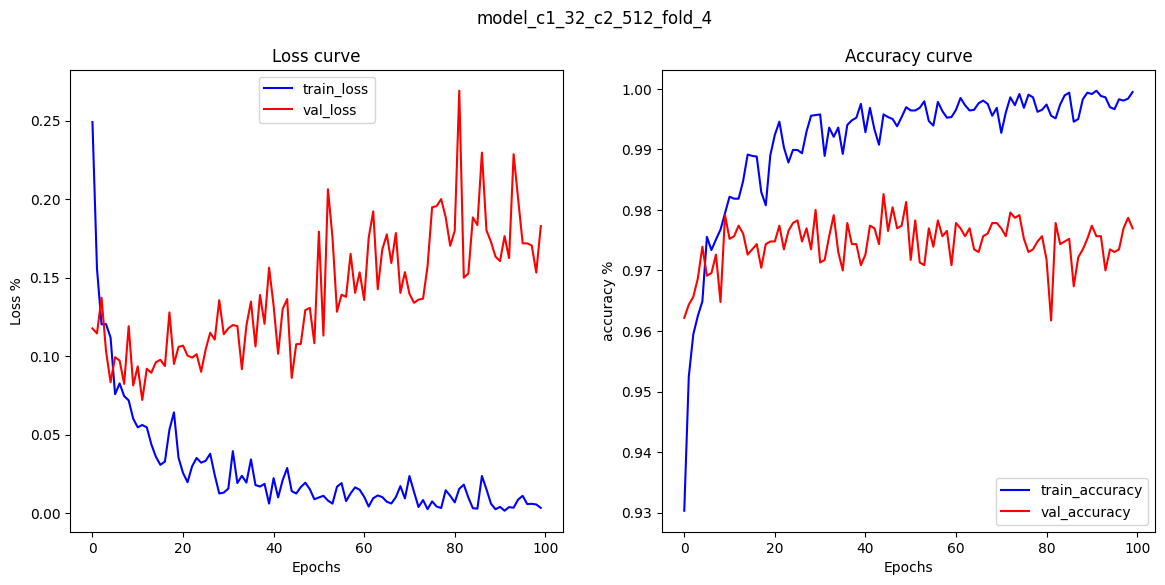



---- fold = 5 --- conv1 unit = 32 ---- conv2 unit = 512 -------

72/72 [==============================] - 0s 6ms/step - loss: 0.1956 - accuracy: 0.9757
c1=32,c2=512 Fold = 5 accuracy: 0.9756521582603455


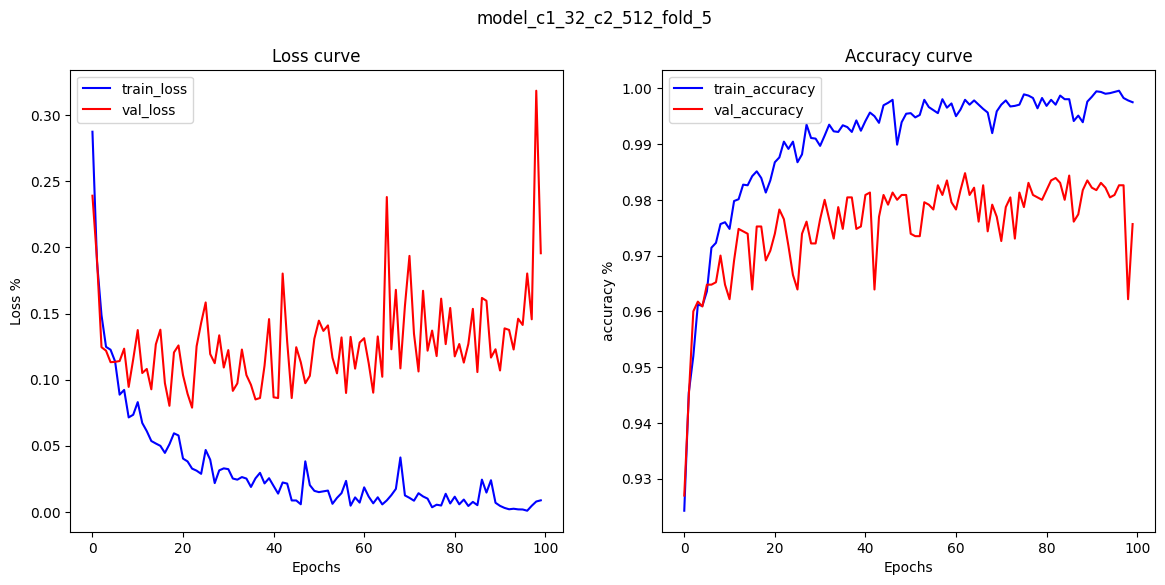

Mean Accuracy: 0.9747825980186462


---- fold = 1 --- conv1 unit = 32 ---- conv2 unit = 1024 -------

72/72 [==============================] - 0s 6ms/step - loss: 0.2226 - accuracy: 0.9626
c1=32,c2=1024 Fold = 1 accuracy: 0.9626086950302124


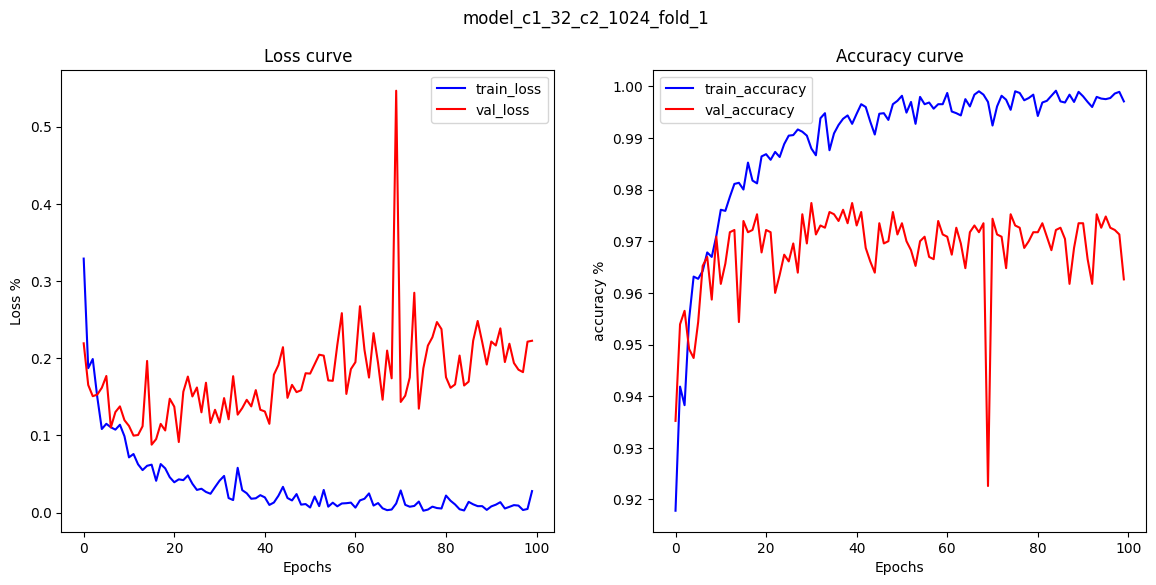



---- fold = 2 --- conv1 unit = 32 ---- conv2 unit = 1024 -------

72/72 [==============================] - 0s 5ms/step - loss: 0.1851 - accuracy: 0.9696
c1=32,c2=1024 Fold = 2 accuracy: 0.969565212726593


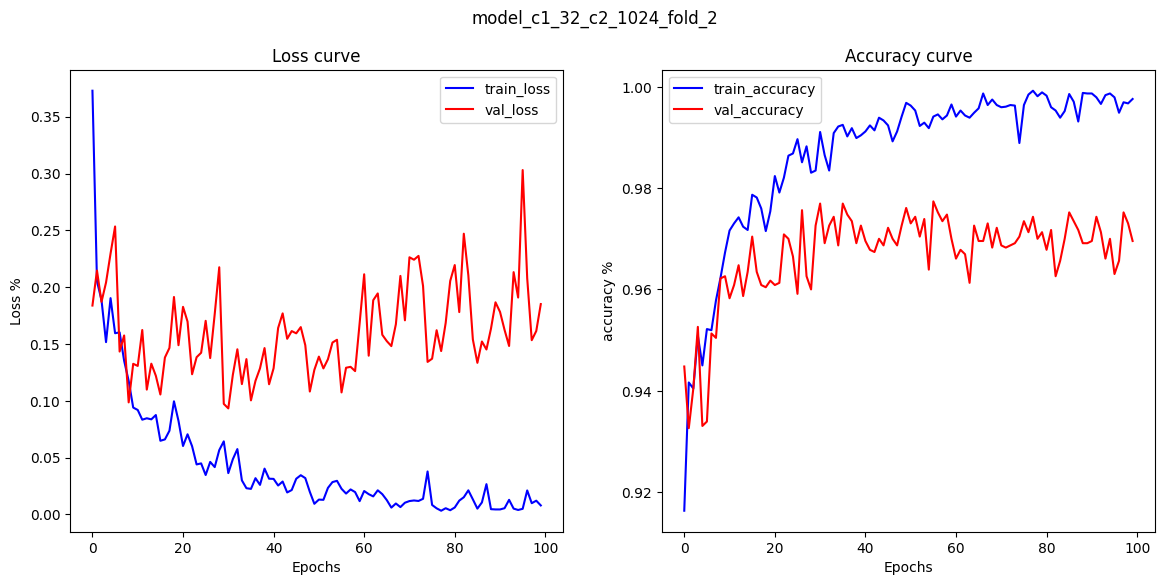



---- fold = 3 --- conv1 unit = 32 ---- conv2 unit = 1024 -------

72/72 [==============================] - 0s 5ms/step - loss: 0.2004 - accuracy: 0.9709
c1=32,c2=1024 Fold = 3 accuracy: 0.9708695411682129


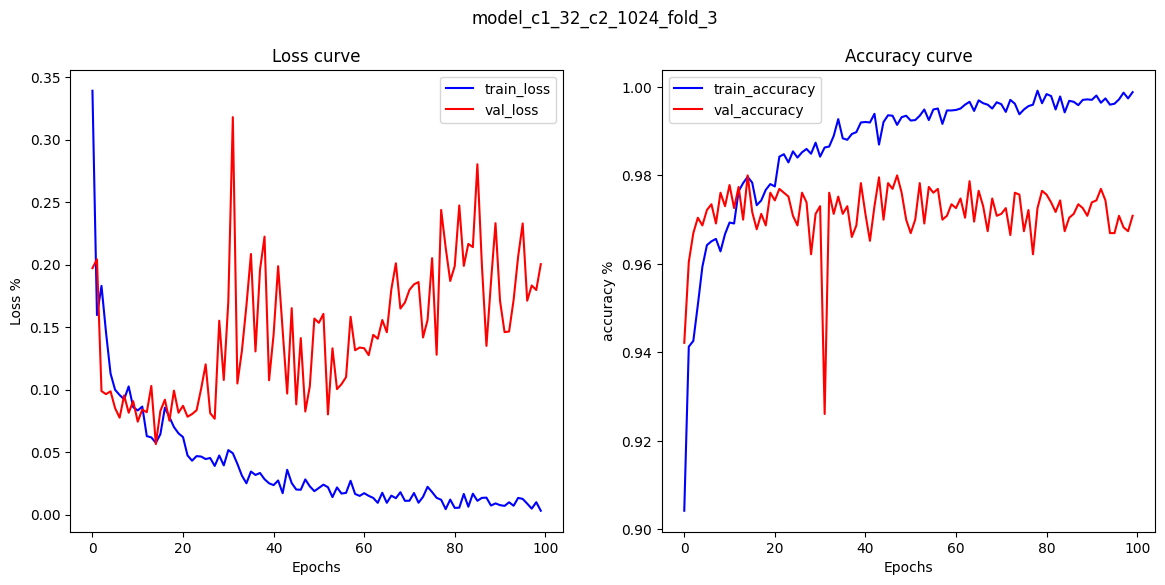



---- fold = 4 --- conv1 unit = 32 ---- conv2 unit = 1024 -------

72/72 [==============================] - 0s 6ms/step - loss: 0.1558 - accuracy: 0.9761
c1=32,c2=1024 Fold = 4 accuracy: 0.9760869741439819


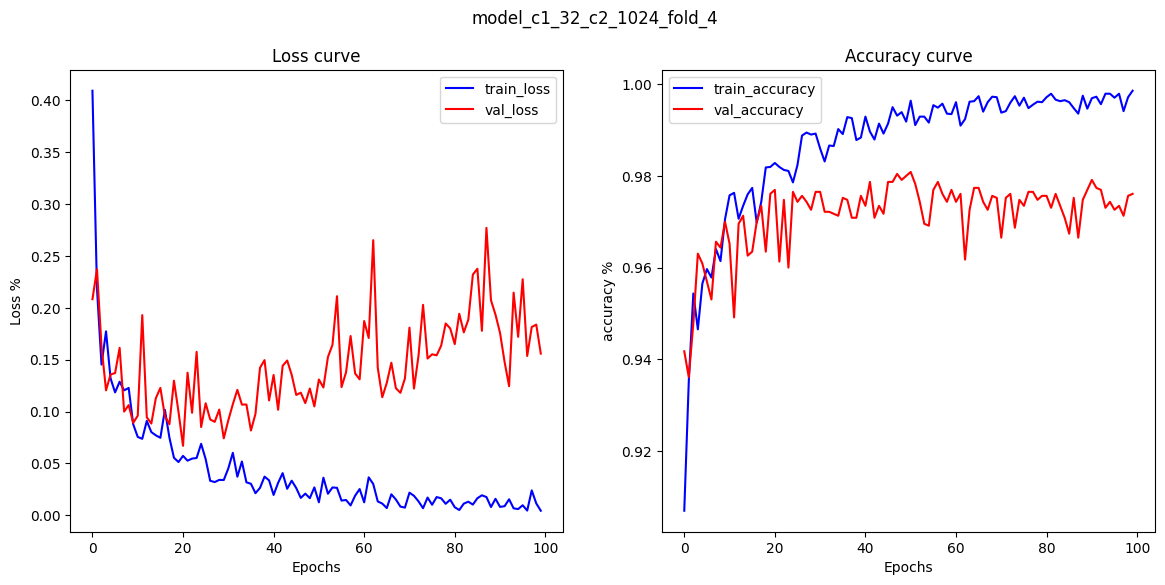



---- fold = 5 --- conv1 unit = 32 ---- conv2 unit = 1024 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1472 - accuracy: 0.9765
c1=32,c2=1024 Fold = 5 accuracy: 0.9765217304229736


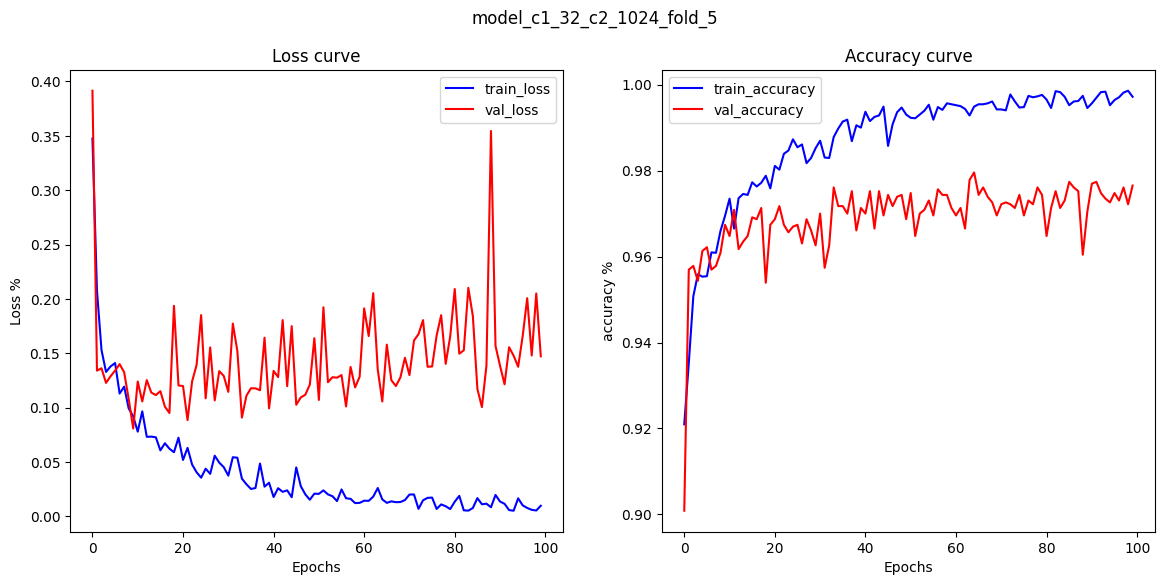

Mean Accuracy: 0.9711304306983948


---- fold = 1 --- conv1 unit = 64 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 5ms/step - loss: 0.2453 - accuracy: 0.9717
c1=64,c2=64 Fold = 1 accuracy: 0.9717391133308411


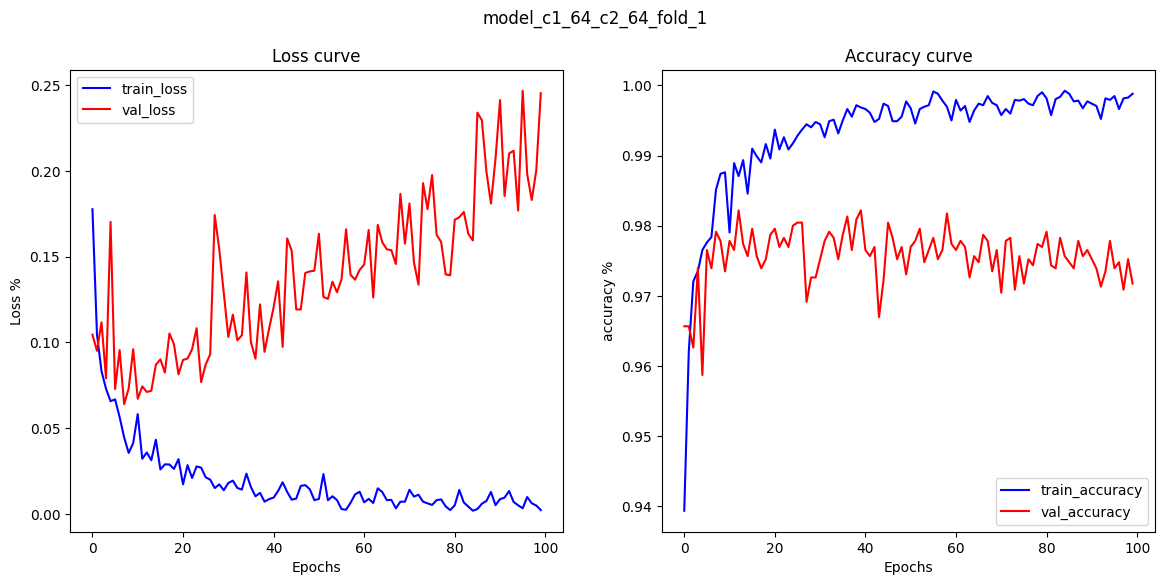



---- fold = 2 --- conv1 unit = 64 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1343 - accuracy: 0.9743
c1=64,c2=64 Fold = 2 accuracy: 0.9743478298187256


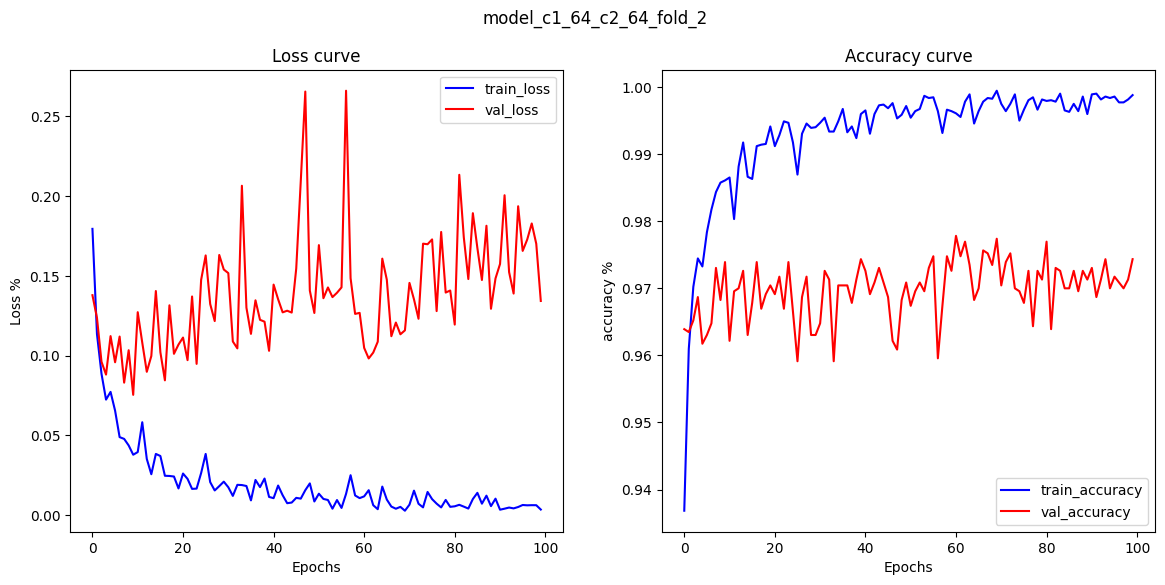



---- fold = 3 --- conv1 unit = 64 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9735
c1=64,c2=64 Fold = 3 accuracy: 0.9734782576560974


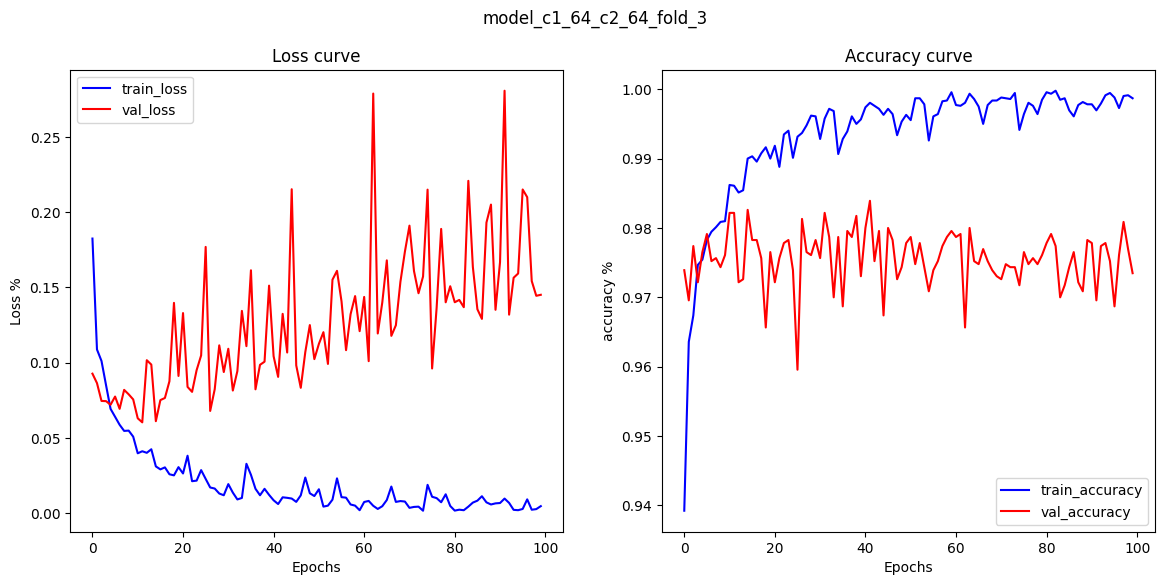



---- fold = 4 --- conv1 unit = 64 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.2211 - accuracy: 0.9735
c1=64,c2=64 Fold = 4 accuracy: 0.9734782576560974


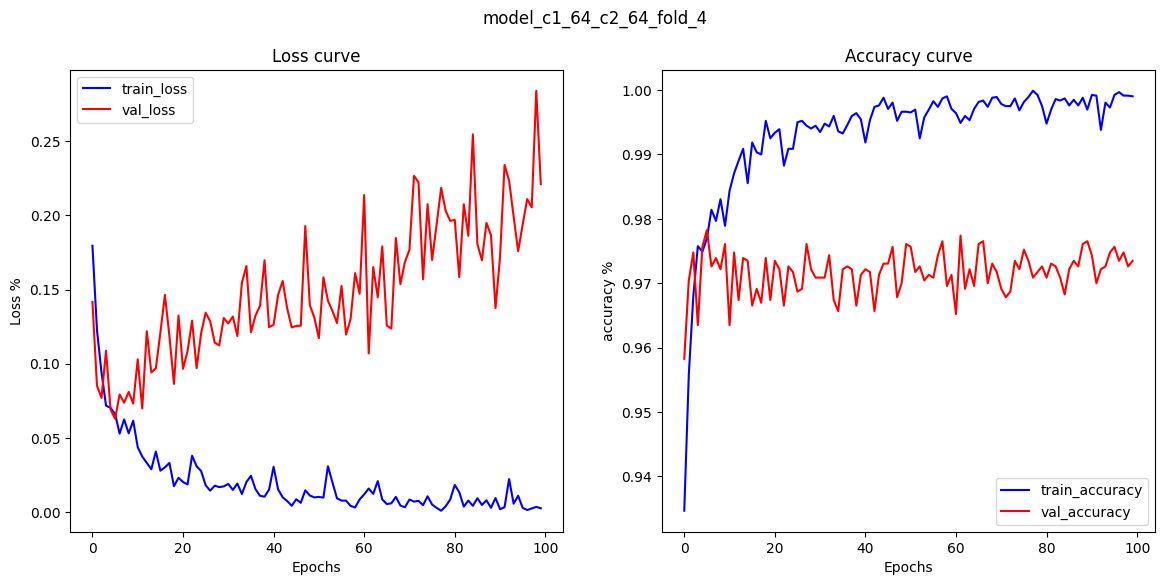



---- fold = 5 --- conv1 unit = 64 ---- conv2 unit = 64 -------

72/72 [==============================] - 0s 4ms/step - loss: 0.1551 - accuracy: 0.9748
c1=64,c2=64 Fold = 5 accuracy: 0.9747825860977173


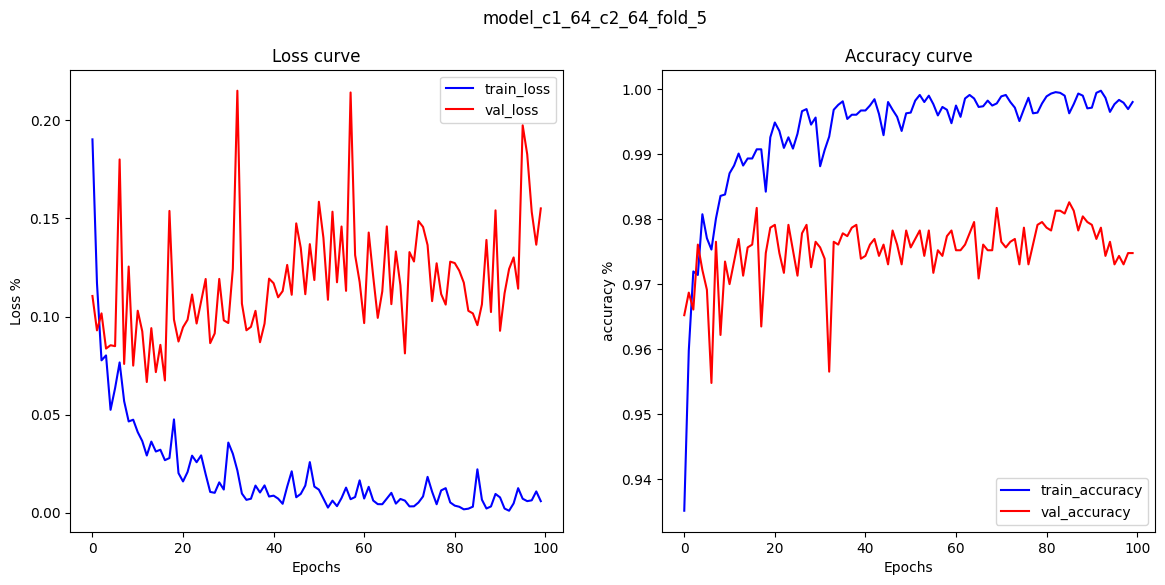

Mean Accuracy: 0.9735652089118958


---- fold = 1 --- conv1 unit = 64 ---- conv2 unit = 128 -------

 1/72 [..............................] - ETA: 1s - loss: 3.4832e-04 - accuracy: 1.0000

In [ ]:
conv1 = [32, 64, 128, 256, 512]
conv2 = [64, 128, 256, 512, 1024]

for c1_units in conv1:
    for c2_units in conv2:
        # Perform cross-validation
        fold_accuracy = []
        fold = 1

        for train_index, val_index in skf.split(X, y):
            X_train, X_val, y_train, y_val, input_shape = process_input(X, y, train_index, val_index)


            # model = eegClassifier(input_shape, c1_units, c2_units)
            model = create_sequential_eeg_model(input_shape, c1_units, c2_units)
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            log_file = f"model_c1_{c1_units}_c2_{c2_units}_fold_{fold}.log"
            model_name = f"model_c1_{c1_units}_c2_{c2_units}_fold_{fold}.h5"

            # Clear existing log handlers and close log files
            root_logger = logging.getLogger()
            for handler in root_logger.handlers:
                handler.close()
            root_logger.handlers.clear()

            # Create a separate log file for each model
            logger = init_logger(log_file, stdout=False)


            logger.info(f"\n\n---- fold = {fold} --- conv1 unit = {c1_units} ---- conv2 unit = {c2_units} -------\n")
            print(f"\n\n---- fold = {fold} --- conv1 unit = {c1_units} ---- conv2 unit = {c2_units} -------\n")

            # Define the checkpoint callback to save the best model
            checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', save_format="h5")

            # Train the model and capture the history
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                                callbacks=[checkpoint], verbose=0)

            # Log loss and accuracy
            for i, (loss, accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
                logger.info(f"Epoch {i+1} - Loss: {loss} - Accuracy: {accuracy}")
            for i, (val_loss, val_accuracy) in enumerate(zip(history.history['val_loss'], history.history['val_accuracy'])):
                logger.info(f"Epoch {i+1} - Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}")


            # Evaluate the model on the test set
            loss_scale_optimizer, accuracy = model.evaluate(X_val, y_val)
            fold_accuracy.append(accuracy)

            # Log fold accuracy
            logger.info(f"c1={c1_units},c2={c2_units} Fold = {fold} accuracy: {accuracy}")

            print(f"c1={c1_units},c2={c2_units} Fold = {fold} accuracy: {accuracy}")
            plot_loss_accuracy(history, f"model_c1_{c1_units}_c2_{c2_units}_fold_{fold}")
            # plot_accuracy(history)

            fold += 1

        # Calculate the average accuracy across all folds
        mean_accuracy = np.mean(fold_accuracy)
        print("Mean Accuracy:", mean_accuracy)